# ルートを評価するために解くLPについて
- ルートが1つ与えられた後、そのルートを評価するためにLPを解く(ルートが実行可能であるとは限らない)

<!--- 各制約の違反度を変数とし、それらに重みをかけて足し合わせた関数の最小化問題とする-->
- 車両が各顧客へ到着する時刻を変数とし、その合計を最小化する問題とする
- 制約は、容量制約と時間枠制約とする
    - 容量制約は、ある区間における2つの関数の積分値(面積)の大小を比較するという形で表す(車両の積荷の量を表す区分線形関数の\[x0, xn\]までの積分値と最大容量を表す線形関数の\[x0, xn\]までの積分値)
    - 時間枠制約は、通常のVRPの定式化と同様に表す


# 前準備

## 問題例の読み込み
使用した問題例 : https://neo.lcc.uma.es/vrp/vrp-instances/description-for-files-of-solomons-instances/

In [1]:
class Customer():
    def __init__(self, x, y, d, e, l, s):
        self.x = x
        self.y = y
        self.d = d
        self.e = e
        self.l = l
        self.s = s

In [2]:
import glob

files = glob.glob("./solomon_25/*")
for file in files:
    print(file)

./solomon_25/R101.txt
./solomon_25/R103.txt
./solomon_25/R102.txt
./solomon_25/R112.txt
./solomon_25/R106.txt
./solomon_25/R107.txt
./solomon_25/R105.txt
./solomon_25/R111.txt
./solomon_25/C108.txt
./solomon_25/RC208.txt
./solomon_25/C109.txt
./solomon_25/R110.txt
./solomon_25/R104.txt
./solomon_25/R201.txt
./solomon_25/R202.txt
./solomon_25/R203.txt
./solomon_25/R207.txt
./solomon_25/R206.txt
./solomon_25/R210.txt
./solomon_25/R204.txt
./solomon_25/C208.txt
./solomon_25/R205.txt
./solomon_25/R211.txt
./solomon_25/RC108.txt
./solomon_25/RC105.txt
./solomon_25/R208.txt
./solomon_25/C205.txt
./solomon_25/C204.txt
./solomon_25/R209.txt
./solomon_25/RC104.txt
./solomon_25/RC106.txt
./solomon_25/R101.txt.distance
./solomon_25/C206.txt
./solomon_25/C207.txt
./solomon_25/RC107.txt
./solomon_25/RC103.txt
./solomon_25/C203.txt
./solomon_25/C202.txt
./solomon_25/RC102.txt
./solomon_25/C201.txt
./solomon_25/RC101.txt
./solomon_25/R109.txt
./solomon_25/C104.txt
./solomon_25/RC204.txt
./solomon_25/

In [3]:
# 問題例の選択
instance = files[0]

In [4]:
Customers = {}
with open(instance, mode="r") as f:
    for index,line in enumerate(f):
        #print(line)
        l = []
        if index==4:
            line_s = [s.strip("\n") for s in line.split("\t")][0]
            for s in line_s.split(" "):
                if s!="":
                    l.append(int(s))
            K, Q = l
        elif 9<=index<=34:
            line_s = [s.strip("\n") for s in line.split("\t")][0]
            for s in line_s.split(" "):
                if s!="":
                    l.append(int(s))
            Customers[l[0]] = Customer(*l[1:])

In [5]:
Customers["depot"] = Customer(0,0,0,0,1000,0)

In [6]:
print("\t", list(vars(Customers[0]).keys()))
for i in Customers.keys():
    print(i, end="\t")
    for key, val in vars(Customers[i]).items():
        print(val, end=" ")
    print()

	 ['x', 'y', 'd', 'e', 'l', 's']
0	35 35 0 0 230 0 
1	41 49 10 161 171 10 
2	35 17 7 50 60 10 
3	55 45 13 116 126 10 
4	55 20 19 149 159 10 
5	15 30 26 34 44 10 
6	25 30 3 99 109 10 
7	20 50 5 81 91 10 
8	10 43 9 95 105 10 
9	55 60 16 97 107 10 
10	30 60 16 124 134 10 
11	20 65 12 67 77 10 
12	50 35 19 63 73 10 
13	30 25 23 159 169 10 
14	15 10 20 32 42 10 
15	30 5 8 61 71 10 
16	10 20 19 75 85 10 
17	5 30 2 157 167 10 
18	20 40 12 87 97 10 
19	15 60 17 76 86 10 
20	45 65 9 126 136 10 
21	45 20 11 62 72 10 
22	45 10 18 97 107 10 
23	55 5 29 68 78 10 
24	65 35 3 153 163 10 
25	65 20 6 172 182 10 
depot	0 0 0 0 1000 0 


## ルートの作成

In [7]:
# 入力
## 顧客
C={} # 客の座標を保存する辞書
TW={} # 客の時間枠を保存する辞書
demand={} # 客の要求量(正の値は集荷，負の値は配達)
S={} # 客のサービス時間

for i in Customers:
    x, y = Customers[i].x, Customers[i].y
    C[i] = (x,y)
    e, l = Customers[i].e, Customers[i].l
    TW[i] = (e,l)
    demand[i] = (Customers[i].d, )
    S[i] = Customers[i].s
    """name="c"+str(i)
    x, y = Customers[i].x, Customers[i].y
    C[name] = (x,y)
    e, l = Customers[i].e, Customers[i].l
    TW[name] = (e,l)
    demand[name] = (Customers[i].d, )
    S[name] = Customers[i].s"""
#C["depot"]=(0,0)

## 車両
M = K//2 # number of vehicles
capacities = [(Q*2, ) for k in range(M)] # capacity of vehicle

In [8]:
print("Customer",C)
print("Time Window",TW)
print("Demand",demand)
print("Service Time",S)

Customer {0: (35, 35), 1: (41, 49), 2: (35, 17), 3: (55, 45), 4: (55, 20), 5: (15, 30), 6: (25, 30), 7: (20, 50), 8: (10, 43), 9: (55, 60), 10: (30, 60), 11: (20, 65), 12: (50, 35), 13: (30, 25), 14: (15, 10), 15: (30, 5), 16: (10, 20), 17: (5, 30), 18: (20, 40), 19: (15, 60), 20: (45, 65), 21: (45, 20), 22: (45, 10), 23: (55, 5), 24: (65, 35), 25: (65, 20), 'depot': (0, 0)}
Time Window {0: (0, 230), 1: (161, 171), 2: (50, 60), 3: (116, 126), 4: (149, 159), 5: (34, 44), 6: (99, 109), 7: (81, 91), 8: (95, 105), 9: (97, 107), 10: (124, 134), 11: (67, 77), 12: (63, 73), 13: (159, 169), 14: (32, 42), 15: (61, 71), 16: (75, 85), 17: (157, 167), 18: (87, 97), 19: (76, 86), 20: (126, 136), 21: (62, 72), 22: (97, 107), 23: (68, 78), 24: (153, 163), 25: (172, 182), 'depot': (0, 1000)}
Demand {0: (0,), 1: (10,), 2: (7,), 3: (13,), 4: (19,), 5: (26,), 6: (3,), 7: (5,), 8: (9,), 9: (16,), 10: (16,), 11: (12,), 12: (19,), 13: (23,), 14: (20,), 15: (8,), 16: (19,), 17: (2,), 18: (12,), 19: (17,), 20

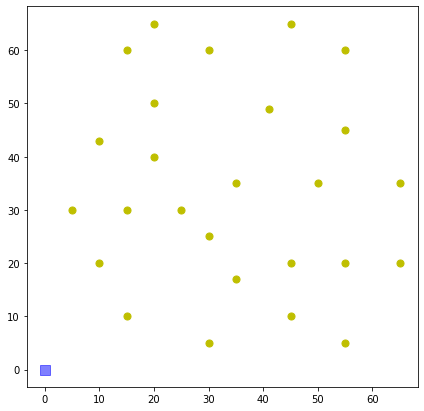

In [9]:
import networkx as nx
import matplotlib.pyplot as plt

fig=plt.figure(figsize=(7,7))

G=nx.DiGraph()
nx.draw_networkx(G,pos=C,nodelist=[i for i in C if i != "depot"],node_color="y",node_size=50,with_labels=True,edge_color="k",width=1)
nx.draw_networkx(G,pos=C,nodelist=["depot"],node_color="blue",node_shape='s',alpha=0.5,node_size=100,with_labels=True,edge_color="k",width=1)

plt.show()

In [10]:
# 距離関数の定義
#def Distance(t1,t2):
#    return ((t1[0]-t2[0])**2+(t1[1]-t2[1])**2)**(0.5)
def distance(x1, y1, x2, y2):
    return ((x2-x1)**2+(y2-y1)**2)**(0.5)

# ソルバーの読み込み
import sys
sys.path.append('..')

#from vrplib.vrp_d_1m1_t_model import *
import vrplib.vrp_d_1m1_t_model as vrp

# ソルバーの実行
model = vrp.Model(file.split("/")[-1].split(".")[0]) # モデルインスタンスの生成

## 客インスタンスの生成
for i in C:
    if i == "depot":
        continue
    model += vrp.Customer(i,demand=demand[i],timewindow=TW[i],servicetime=S[i])

## 車両インスタンスの生成
for k in range(M):
    model += vrp.Vehicle("v"+str(k),capacity=capacities[k])
    
## 枝インスタンスの生成
for i in C:
    for j in C:
        if i!=j:
            dist = time = distance(*C[i],*C[j])
            model += vrp.Edge(i,j,dist,time)

In [11]:
## 最適化の実行
obj=model.optimize(IterLimit=100,TimeLimit=1,Verbose=False,OutputFlag=False)

## 得られた解の表示
print("objective value =",obj)
for v in model.vehiclesL:
    print()
    print(v)
    print(list(map(lambda x:x.name,v.routing[1:-1])))    
    for iv in map(lambda x:x.name,v.routing[1:-1]):
        print(iv)

objective value = 1211.62

Vehicle v0: {'capacity': (400,)}
173.07639 = {'distance': 173.07639, 'freight_1M1': 0.0, 'timecost': 0.0}
[0, 9, 20, 1]
0
9
20
1

Vehicle v1: {'capacity': (400,)}
36.055513 = {'distance': 36.055513, 'freight_1M1': 0.0, 'timecost': 0.0}
[14]
14

Vehicle v2: {'capacity': (400,)}
117.873959 = {'distance': 117.873959, 'freight_1M1': 0.0, 'timecost': 0.0}
[2, 21, 4]
2
21
4

Vehicle v3: {'capacity': (400,)}
67.082039 = {'distance': 67.082039, 'freight_1M1': 0.0, 'timecost': 0.0}
[5]
5

Vehicle v4: {'capacity': (400,)}
60.827625 = {'distance': 60.827625, 'freight_1M1': 0.0, 'timecost': 0.0}
[17]
17

Vehicle v5: {'capacity': (400,)}
164.129669 = {'distance': 164.129669, 'freight_1M1': 0.0, 'timecost': 0.0}
[11, 19, 10, 13]
11
19
10
13

Vehicle v6: {'capacity': (400,)}
169.362606 = {'distance': 169.362606, 'freight_1M1': 0.0, 'timecost': 0.0}
[12, 3, 24, 25]
12
3
24
25

Vehicle v7: {'capacity': (400,)}
112.504867 = {'distance': 112.504867, 'freight_1M1': 0.0, 'timecos

## ルートを1つ選ぶ

In [12]:
# Vehicle 6の巡回路を選んでいる
tour = [12, 3, 24, 25]#+["depot"]

## その他作業

In [13]:
# 使用した問題例の名称を保存
tmp = []
for s in instance[-1:0:-1]:
    if s=='/':
        break
    tmp.append(s)
instance_name = "".join(tmp[-1:0:-1])
print(instance_name)

R101.tx


# 問題を解く
2つの手法に対し、計算時間を比較

## 入力する行列、ベクトルの作成

In [14]:
def make_preceding_constr(tour, Customers, Ax, Ap, b, c):
    # ルート内の顧客の順序に関する制約
    for index, i in enumerate(tour):
        try:
            i_next = tour[index+1]
        except:
            i_next = "depot"
            continue
        Ax.append([1 if target==i else -1 if target==i_next else 0 for target in tour])
        Ap.append([0 for _ in range(len(tour))])
        b.append(-distance(Customers[i].x, Customers[i].y, Customers[i_next].x, Customers[i_next].y))
    return Ax, Ap, b, c

In [15]:
def make_tw_constr(tour, Customers, Ax, Ap, b, c):
    # 時間枠制約
    for index, i in enumerate(tour):
        Ax.append([-1 if i==target else 0 for index_, target in enumerate(tour)])
        Ap.append([-1 if i==target else 0 for index_, target in enumerate(tour)])
        b.append(-Customers[i].e)
        Ax.append([1 if i==target else 0 for index_, target in enumerate(tour)])
        Ap.append([-1 if i==target else 0 for index_, target in enumerate(tour)])
        b.append(Customers[i].l)
    return Ax, Ap, b, c

In [16]:
def make_inputs(tour, Customers):
    import numpy as np
    Ax, Ap, b, c = [], [], [], [1 for _ in range(len(tour))]
    # ルート内の顧客の順序に関する制約
    Ax, Ap, b, c = make_preceding_constr(tour, Customers, Ax, Ap, b, c)
    # 時間枠制約
    Ax, Ap, b, c = make_tw_constr(tour, Customers, Ax, Ap, b, c)
    # ndarrayに変換
    Ax = np.array(Ax)
    Ap = np.array(Ap)
    b = np.array(b)
    c = np.array(c)
    return Ax, Ap, b, c

## 主問題を解く関数の定義
与えられた定数を元にLPのモデルを作成した上でそれを解き、最適解を返す関数

In [17]:
def solve_primal(Ax, Ap, b, c, instance_name, num_vars):
    import gurobipy as gp
    from gurobipy import GRB
    import numpy as np
    import time
    
    # インスタンスの生成
    m = gp.Model("LP_for_VRP" + instance_name)
    # 定数を設定　←　入力として与えられる
    # 変数を設定
    """
    x_i : 顧客iへ車両が到着する時刻を表す変数
    p_i : 顧客iの時間枠の違反度を表す変数
    """
    x = m.addMVar(shape=num_vars, vtype=GRB.CONTINUOUS, name="x")
    p = m.addMVar(shape=num_vars, vtype=GRB.CONTINUOUS, name="p")

    # モデルのアップデート
    m.update()
    
    # 目的関数を設定
    ## 各制約の違反度を最小化する
    m.setObjective(c.T @ p, sense=gp.GRB.MINIMIZE)
    
    # 制約条件を設定
    m.addConstr(Ax @ x + Ap @ p <= b, name="c")

    # モデルのアップデート
    m.update()
    
    # 時間計測スタート
    start = time.time()
    
    # 最適化
    m.optimize()
    
    # 時間計測ストップ
    elapsed_time = time.time() - start
    
    # 解の表示
    if m.Status == gp.GRB.OPTIMAL:
        for i in range(num_vars):
            print(f"車両が顧客{i}に到着する時刻は、{x[i].X}")
        print("最適値 : ", m.ObjVal)
    print('\033[34m'+f"実時間\t{elapsed_time}"+'\033[0m')
        
    return m

## 双対問題を解く関数の定義

In [18]:
def solve_dual(Ax, Ap, b, c, instance_name, num_vars, basis_like):
    import gurobipy as gp
    from gurobipy import GRB
    import numpy as np
    import time
    
    # インスタンスの生成
    m = gp.Model("LP_for_VRP" + instance_name)
    
    # 変数を設定
    """
    y_i : 主問題における制約式iの潜在価値
    """
    y = m.addMVar(shape=num_vars, vtype=GRB.CONTINUOUS, name="y")

    # モデルのアップデート
    m.update()
    
    # 目的関数を設定
    ## 各制約の違反度を最小化する
    m.setObjective(b.T @ y, sense=gp.GRB.MAXIMIZE)
    
    # 制約条件を設定
    m.addConstr(Ax.T @ y == 0, name="c1")
    m.addConstr(Ap.T @ y + c == 0, name="c2")
    m.addConstr(y >= 0, name="c3")

    # モデルのアップデート
    m.update()
    
    # 時間計測スタート
    start = time.time()
    
    # ホットスタートの使用
    for i in range(num_vars):
        y[i].PStart = basis_like[i]
    
    # 最適化
    m.optimize()
    
    # 時間計測ストップ
    elapsed_time = time.time() - start
    
    # 解の表示
    if m.Status == gp.GRB.OPTIMAL:
        for i in range(num_vars):
            print(f"主問題における制約{i}の潜在価格は、{y[i].X}")
        print("最適値 : ", m.ObjVal)
    print('\033[34m'+f"実時間\t{elapsed_time}"+'\033[0m')
        
    return m

## ①全体を1つのLPとして解くveb.
1. ルートが与えられる
1. Primalを解く

### 1. ルートが与えられる

### 2. 全体のPrimalを解く

In [42]:
Ax, Ap, b, c = make_inputs(tour, Customers)

In [20]:
# Gurobiによって最適解を求める
whole_x = solve_primal(Ax, Ap, b, c, instance_name+"whole_x", len(tour))

Using license file /Users/okamoto/gurobi.lic
Academic license - for non-commercial use only
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 11 rows, 8 columns and 22 nonzeros
Model fingerprint: 0x5007f038
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 2e+02]
Presolve removed 2 rows and 1 columns
Presolve time: 0.01s
Presolved: 9 rows, 7 columns, 18 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   1.792810e+02   0.000000e+00      0s
       3    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 3 iterations and 0.02 seconds
Optimal objective  0.000000000e+00
車両が顧客0に到着する時刻は、[63.]
車両が顧客1に到着する時刻は、[116.]
車両が顧客2に到着する時刻は、[153.]
車両が顧客3に到着する時刻は、[182.]
最適値 :  0.0
実時間	0.02517104148864746


In [21]:
for constr in whole_x.getConstrs():
    print(constr.Pi)

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


## ②前半と後半をつなげるveb.
1. ルートが与えられる
1. 適当なところで前後に分ける
1. 前半後半それぞれのPrimalを解く
1. 前半と後半それぞれのPrimalの最適解を、全体のDualに入れて解く(つなげる際に必要になる制約A3を考えなければならない)
1. Primalの解を相補正条件によって復元

### 2. 適当なところで前後に分ける
- ひとまず半分くらいで分けることにする

In [22]:
threshold = len(tour)//2
#print(threshold)

former = tour[:threshold]
latter = tour[threshold:]
print(f"巡回路全体は、{tour}")
print(f"前半は、{former}")
print(f"後半は、{latter}")

巡回路全体は、[12, 3, 24, 25]
前半は、[12, 3]
後半は、[24, 25]


### 3. 前半後半それぞれのPrimalを解く

In [23]:
import numpy as np
# 係数行列、ベクトルを整える
A1x, A1p, A2x, A2p, A3x, A3p, b1, b2, b3, c1, c2 = [], [], [], [], [], [], [], [], [], [], []
## A1, A2, A3を定める
## b1, b2, b3を定める
for Ax_i, Ap_i, b_i in zip(Ax, Ap, b):
    if np.linalg.norm(Ax_i[threshold:], ord=2)==0.:
        A1x.append(Ax_i[:threshold])
        A1p.append(Ap_i[:threshold])
        b1.append(b_i)
    elif np.linalg.norm(Ax_i[:threshold], ord=2)==0.:
        A2x.append(Ax_i[threshold:])
        A2p.append(Ap_i[threshold:])
        b2.append(b_i)
    else:
        A3x.append(Ax_i)
        A3p.append(Ap_i)
        b3.append(b_i)
## c1, c2, c3を定める
c1 = c[:threshold]
c2 = c[threshold:]
    
## リストからnumpy arrayに変換
A1x = np.array(A1x)
A1p = np.array(A1p)
A2x = np.array(A2x)
A2p = np.array(A2p)
A3x = np.array(A3x)
A3p = np.array(A3p)
b1 = np.array(b1)
b2 = np.array(b2)
b3 = np.array(b3)
c1 = np.array(c1)
c2 = np.array(c2)
for i in range(1, 4):
    print(f"A{i}x : ", end="")
    print(eval("A"+str(i)+"x"))
    print(f"A{i}p : ", end="")
    print(eval("A"+str(i)+"p"))
    print(f"b{i} : ", end="")
    print(eval("b"+str(i)))
    if i <= 2:
        print(eval("c"+str(i)))

A1x : [[ 1 -1]
 [-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]
A1p : [[ 0  0]
 [-1  0]
 [-1  0]
 [ 0 -1]
 [ 0 -1]]
b1 : [ -11.18033989  -63.           73.         -116.          126.        ]
[1 1]
A2x : [[ 1 -1]
 [-1  0]
 [ 1  0]
 [ 0 -1]
 [ 0  1]]
A2p : [[ 0  0]
 [-1  0]
 [-1  0]
 [ 0 -1]
 [ 0 -1]]
b2 : [ -15. -153.  163. -172.  182.]
[1 1]
A3x : [[ 0  1 -1  0]]
A3p : [[0 0 0 0]]
b3 : [-14.14213562]


In [24]:
# Gurobiによって最適解を求める
former_x = solve_primal(A1x, A1p, b1, c1, instance_name+"former_x", len(former))
latter_x = solve_primal(A2x, A2p, b2, c2, instance_name+"latter_x", len(latter))

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 5 rows, 4 columns and 10 nonzeros
Model fingerprint: 0x5e79c72b
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+01, 1e+02]
Presolve removed 2 rows and 1 columns
Presolve time: 0.03s
Presolved: 3 rows, 3 columns, 6 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    0.0000000e+00   6.300000e+01   0.000000e+00      0s
       1    0.0000000e+00   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.06 seconds
Optimal objective  0.000000000e+00
車両が顧客0に到着する時刻は、[63.]
車両が顧客1に到着する時刻は、[126.]
最適値 :  0.0
実時間	0.07782888412475586
Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 5 rows, 4 columns and 10 nonzeros
Model fingerprint: 0x49be07ce
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     

In [25]:
for v in former_x.getVars():
        print('%s %g %g' % (v.varName, v.x, v.VBasis))

x[0] 63 0
x[1] 126 0
p[0] 0 -1
p[1] 0 -1


In [26]:
for v in latter_x.getVars():
        print('%s %g %g' % (v.varName, v.x, v.VBasis))

x[0] 153 0
x[1] 182 0
p[0] 0 -1
p[1] 0 -1


In [27]:
for constr in former_x.getConstrs()+latter_x.getConstrs():
    print(constr.Pi, constr.CBasis)

0.0 0
0.0 -1
0.0 0
0.0 0
0.0 -1
0.0 0
0.0 -1
0.0 0
0.0 0
0.0 -1


### 4. 前半後半それぞれのPrimalの最適解を、全体のDualに入れて解く

In [30]:
# 初期解の保存
basis_like = np.array([constr.Pi for constr in former_x.getConstrs()+latter_x.getConstrs()])
y3 = np.zeros((Ax.shape[0]-basis_like.shape[0],))
basis_like = np.append(basis_like, y3)

In [47]:
print(f"Ax.T.shape={Ax.T.shape}\t\t\tAp.T.shape={Ap.T.shape}")
for Ax_i, Ap_i in zip(Ax.T, Ap.T):
    print(Ax_i, "\t", Ap_i)

Ax.T.shape=(4, 11)			Ap.T.shape=(4, 11)
[ 1  0  0 -1  1  0  0  0  0  0  0] 	 [ 0  0  0 -1 -1  0  0  0  0  0  0]
[-1  1  0  0  0 -1  1  0  0  0  0] 	 [ 0  0  0  0  0 -1 -1  0  0  0  0]
[ 0 -1  1  0  0  0  0 -1  1  0  0] 	 [ 0  0  0  0  0  0  0 -1 -1  0  0]
[ 0  0 -1  0  0  0  0  0  0 -1  1] 	 [ 0  0  0  0  0  0  0  0  0 -1 -1]


In [34]:
# Gurobiによって最適解を求める
whole_y = solve_dual(Ax, Ap, b, c, instance_name+"whole_y", basis_like.shape[0], basis_like)

Gurobi Optimizer version 9.0.2 build v9.0.2rc0 (mac64)
Optimize a model with 19 rows, 11 columns and 33 nonzeros
Model fingerprint: 0xc1514e98
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+01, 2e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 1e+00]
Presolve removed 17 rows and 8 columns
Presolve time: 0.01s
Presolved: 2 rows, 3 columns, 4 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    3.8181966e+02   1.000000e+00   0.000000e+00      0s
       1    1.1153539e+02   0.000000e+00   0.000000e+00      0s

Solved in 1 iterations and 0.01 seconds
Optimal objective  1.115353889e+02
主問題における制約0の潜在価格は、[1.]
主問題における制約1の潜在価格は、[2.]
主問題における制約2の潜在価格は、[1.]
主問題における制約3の潜在価格は、[1.]
主問題における制約4の潜在価格は、[0.]
主問題における制約5の潜在価格は、[1.]
主問題における制約6の潜在価格は、[0.]
主問題における制約7の潜在価格は、[0.]
主問題における制約8の潜在価格は、[1.]
主問題における制約9の潜在価格は、[0.]
主問題における制約10の潜在価格は、[1.]
最適値 :  111.53538886503915
実時間	0.019119977951049805


### 5. Primalの解を復元(相補正条件)

In [36]:
for var in whole_y.getVars():
    print(var.varName, var.X)

y[0] 1.0
y[1] 2.0
y[2] 1.0
y[3] 1.0
y[4] 0.0
y[5] 1.0
y[6] 0.0
y[7] 0.0
y[8] 1.0
y[9] 0.0
y[10] 1.0


In [40]:
for i, constr in enumerate(whole_y.getConstrs()):
    print(constr.Pi)

109.81966011250105
121.0
135.14213562373095
150.14213562373095
-46.819660112501055
-5.0
-27.85786437626905
-31.85786437626905
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [41]:
for var in whole_x.getVars():
    print(var.varName, var.X)

x[0] 63.0
x[1] 116.0
x[2] 153.0
x[3] 182.0
p[0] 0.0
p[1] 0.0
p[2] 0.0
p[3] 0.0
